<a href="https://colab.research.google.com/github/dlinnlp2023/material/blob/main/DLinNLP_Day_2_Session_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The year 2018 marked an exhilarating period in the realm of Natural Language Processing. Notably, a significant advancement emerged in the form of transfer learning. Innovations like Elmo Embeddings, ULMFit, and BERT introduced us to the potential of pre-training neural networks on extensive sets of unlabeled text data. By leveraging auxiliary tasks like language modeling, these models gained profound insights into the intricate aspects of syntax, semantics, and language structure. This newfound knowledge holds immense value: owing to their deep understanding of language dynamics, these models demand considerably less annotated data to achieve cutting-edge performance in diverse tasks, including text classification, sequence labeling, and question answering.

The entire tutorial revolves around a single architecture: the Transformer. Since its publication in 2017, the Transformer has revolutionized the field of NLP, finding successful applications in language modeling, sequence classification, sequence-to-sequence tasks such as machine translation, and many more.

As most common NLP libraries provide off-the-shelf, often pre-trained models, the actual inner working -- what it is going on in the model -- is often obfuscated to the practitioner.


**Basics of the transformer model**

The Transformer is an encoder-decoder neural network originally devised for sequence-to-sequence tasks. Assuming that you are familiar with the notion of neural network, let's clarify the other bits:

*   an encoder is a model that turns a raw piece of data into some meaningful hidden representation;
*   conversely, a decoder is a model that, given a hidden representation, brings the data back into the original domain;

*   A sequence-to-sequence task framed in the NLP domain requires learning a model that turns some sequence into another one. As you can imagine, sequences are frequently made of words.

Let's briefly introduce the encoder and decoder and their respective core logic.


**Encoder**

The goal of the encoder is to turn a list of words into a list of meaningful, dense hidden representations such that other components (e.g., the decoder or other networks) can use them.

The Transformer Encoder (Figure below, left) receives as input a sequence of items (in our case, words), often referred to as the source sequence. Then, it mixes input words using Attention, then feeds the results to a fully-connected feed-forward block with point-wise non-linear activation. Both the operations apply residual connection and layer normalization. This computation is repeated
 times by identical, stacked replicas to compute the final word representations.

 **Decoder**

 The goal of the decoder is to learn the alignment between the source and target sequences. For instance, in the machine translation task, the decoder learns what words to produce in the target language, given the words in the source language.

Like the encoder, the Transformer Decoder (Figure below, right) can receive words' representations as inputs. During training time, it gets the target sentence to learn an association with the source.

Crucially, the decoder has two attention operations, with the first running a masked self-attention and the second one attending to the encoder output.

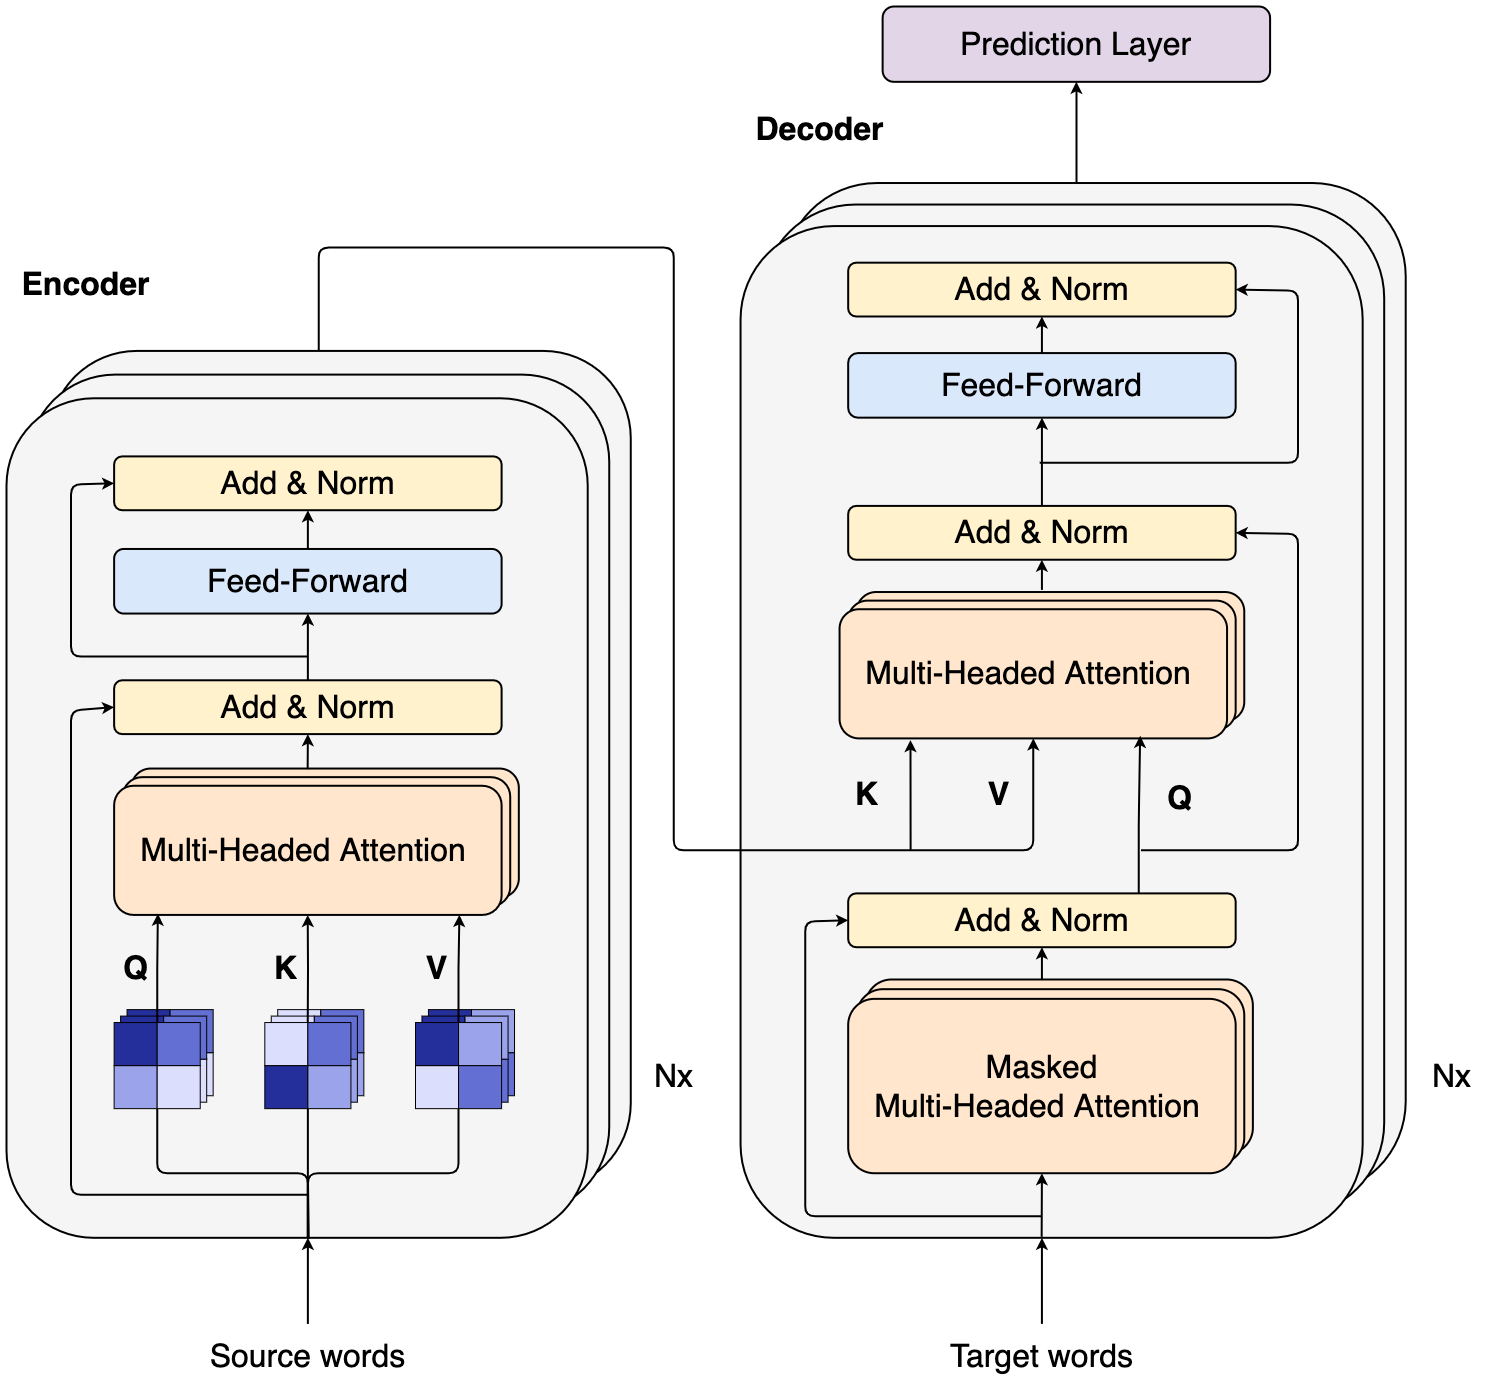

### *References*

Original paper: [Attention is All you Need](https://proceedings.neurips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)

Thorough guide on Transformer components: [Formal Definitions in Trasformers ](https://arxiv.org/pdf/2207.09238.pdf)

Practical PyTorch Transformer walkthrough: [The Annotated Transform](http://nlp.seas.harvard.edu/annotated-transformer/http://nlp.seas.harvard.edu/annotated-transformer/)

If you want to train a transformer form the strach. Follow the below links. These will guide you to develop your own model.

*   [Train your Tokenizer](https://github.com/huggingface/notebooks/blob/main/examples/tokenizer_training.ipynb)
*  [ Train your language model](https://https://github.com/huggingface/notebooks/blob/main/examples/language_modeling_from_scratch.ipynb)



---



## **Fine tunning transformer model for binary classification**

Method 01 : Using Huggingface Tutorial

In [ ]:
# Insatll the dataset from the hugging face
!pip install transformers datasets evaluate accelerate

In [ ]:
import accelerate
import transformers
from datasets import load_dataset
from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
import evaluate
import numpy as np
from transformers import pipeline
from sklearn.metrics import precision_recall_fscore_support as score

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

In [ ]:
# Load dataset from the hugging face
imdb = load_dataset("imdb")

In [ ]:
imdb["test"][0]

{'text': 'I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn\'t match the background, and painfully one-dimensional characters cannot be overcome with a \'sci-fi\' setting. (I\'m sure there are those of you out there who think Babylon 5 is good sci-fi TV. It\'s not. It\'s clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It\'s really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it\'s rubbish as 

In [ ]:
# Import tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [ ]:
# Import Preprocessor
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_imdb = imdb.map(preprocess_function, batched=True)

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="my_awesome_model",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

trainer.save_model()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.294500,0.196967,0.922200


In [ ]:
test_text = imdb["test"].remove_columns('label')
tokenized_sample_test = test_text.map(preprocess_function, batched=True)

predictions = trainer.predict(tokenized_sample_test)

print(predictions)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

PredictionOutput(predictions=array([[ 1.895158  , -2.3988483 ],
       [ 0.7194216 , -1.1776286 ],
       [ 1.6466172 , -2.0471938 ],
       ...,
       [-0.549123  ,  0.3854877 ],
       [-0.75191164,  0.49504542],
       [-1.2599758 ,  1.0330484 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 428.1585, 'test_samples_per_second': 58.39, 'test_steps_per_second': 1.826})


In [ ]:

preds_flat = [np.argmax(x) for x in predictions[0]]

print(len(preds_flat))
preds_flat

25000


[0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,


## Method  02: Simple transformer method

In [ ]:
!pip install simpletransformers

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import pandas as pd
import logging

In [ ]:
train_set = imdb['train']
test_set = imdb['test']

train_set
test_set

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
list_of_train_sets= [[entry['text'], entry['label']] for entry in train_set]
list_of_test_sets= [[entry['text'], entry['label']] for entry in test_set]


In [ ]:
list_of_train_sets[1000]

['Although I have to admit I laughed more watching this movie than the last few comedies I saw.<br /><br />The budget must have consisted of pocket change from the actors. The production values are so low that they actual made it kind of fun to watch. Reminds me of the Robot Monster made up of a guy in a gorilla suit with a cardboard diving helmet on.<br /><br />In one scene a hapless victim gets their arm and leg cut off. Geez, hard to believe but the Black Knight scene from Holy Grail was more realistic. I kept wondering why the victim didn\'t start shouting " None Shall Pass" and " It\'s only a flesh wound, I\'ve had worse". It was one of the funniest scenes I\'ve seen in the past year.<br /><br />The "gladiator/demon" was a stitch too. Between the horribly cheap costume and the geeky look of the guy in it the end result was hysterical.<br /><br />Truly a movie that is bad enough to be watchable. Kind of like seeing a slow motion auto accident on film.<br /><br />',
 0]

In [ ]:
selected_elements_train = list_of_train_sets[:4000]
selected_elements_eval =  list_of_train_sets[4000:5000]
selected_elements_test = list_of_test_sets[:500]

In [ ]:
# Preparing train data
train_data = selected_elements_train
train_df = pd.DataFrame(train_data)

train_df.columns = ["text", "labels"]

# Preparing eval data
eval_data = selected_elements_eval

eval_df = pd.DataFrame(eval_data)
eval_df.columns = ["text", "labels"]


### Train model

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1,
                                overwrite_output_dir =True,
                        )
# Create a ClassificationModel
model = ClassificationModel(
    "bert", "bert-base-cased", args=model_args
)

# Train the model
model.train_model(train_df)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/500 [00:00<?, ?it/s]

(500, 0.027838093608617782)

In [ ]:
# Make predictions with the model
predictions, raw_outputs = model.predict([" I love the food"])
predictions[0]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

0

In [ ]:
test_set = imdb["test"]
test_set

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})

In [ ]:
num_instances = 10
test_texts = [example["text"] for example in test_set]
print(test_texts)

# Generate predictions for the limited test set
predictions, raw_outputs = model.predict(test_texts[:num_instances])

# Print the generated predictions
for i, prediction in enumerate(predictions):
    print(f"Example {i+1} Prediction: {prediction}\n")


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Example 1 Prediction: 0

Example 2 Prediction: 0

Example 3 Prediction: 0

Example 4 Prediction: 0

Example 5 Prediction: 0

Example 6 Prediction: 0

Example 7 Prediction: 0

Example 8 Prediction: 0

Example 9 Prediction: 0

Example 10 Prediction: 0



# Multi class classification

**Task to attempt !!!**




Write a code to multiclass classification for given dataset either using one of above discussed methods

> The AG's news topic classification dataset is constructed by choosing 4 largest classes

> The class ids are numbered 1-4 where 1 represents World, 2 represents Sports, 3 represents Business and 4 represents Sci/Tech.

Link: [Data Description](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset)

In [ ]:
#Your code goes here